# Short-Term Average / Long-Term Average (STA/LTA)


### Import Packages


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import obspy
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

In [2]:
catalog = pd.read_csv(
    r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
)

files = os.listdir(r"../../data/lunar/training/data/S12_GradeA")
csvs = [file for file in files if file.endswith(".csv")]
mseeds = [file for file in files if file.endswith(".mseed")]

print(csvs)
print(mseeds)

['xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', 'xa.s12.00.mhz.1970-03-25HR00_evid00003.csv', 'xa.s12.00.mhz.1970-03-26HR00_evid00004.csv', 'xa.s12.00.mhz.1970-04-25HR00_evid00006.csv', 'xa.s12.00.mhz.1970-04-26HR00_evid00007.csv', 'xa.s12.00.mhz.1970-06-15HR00_evid00008.csv', 'xa.s12.00.mhz.1970-06-26HR00_evid00009.csv', 'xa.s12.00.mhz.1970-07-20HR00_evid00010.csv', 'xa.s12.00.mhz.1970-07-20HR00_evid00011.csv', 'xa.s12.00.mhz.1970-09-26HR00_evid00013.csv', 'xa.s12.00.mhz.1970-10-24HR00_evid00014.csv', 'xa.s12.00.mhz.1970-11-12HR00_evid00015.csv', 'xa.s12.00.mhz.1970-12-11HR00_evid00017.csv', 'xa.s12.00.mhz.1970-12-27HR00_evid00019.csv', 'xa.s12.00.mhz.1970-12-31HR00_evid00021.csv', 'xa.s12.00.mhz.1971-01-15HR00_evid00022.csv', 'xa.s12.00.mhz.1971-01-28HR00_evid00023.csv', 'xa.s12.00.mhz.1971-01-29HR00_evid00024.csv', 'xa.s12.00.mhz.1971-02-09HR00_evid00026.csv', 'xa.s12.00.mhz.1971-03-25HR00_evid00028.csv', 'xa.s12.00.mhz.1971-04-13HR00_evid00029.csv', 'xa.s12.00.mhz.1971-04-17HR00_evi

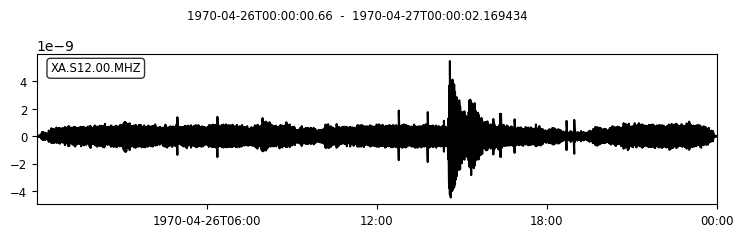

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-04-26T00:00:00.660000Z - 1970-04-27T00:00:02.169434Z | 6.6 Hz, 572411 samples


In [4]:
mseed = mseeds[4]
train = obspy.read(r"../../data/lunar/training/data/S12_GradeA/" + mseed)
train.plot()
print(train)

Text(0, 0.5, 'Characteristic function')

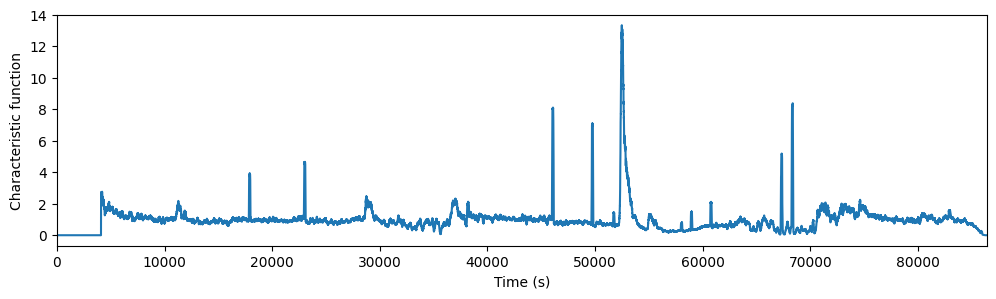

In [23]:
tr = train.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 128
lta_len = 4096

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, cft)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Characteristic function")

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins.
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends.


In [24]:
print(np.max(cft))
print(np.mean(cft))
print(np.std(cft))

13.346950641213056
0.9905676452630191
0.9265038844799028


[[152233 153063]
 [304816 305785]
 [329217 330121]
 [346728 353185]
 [445773 446497]
 [452224 453225]]
[2.176656550624203e-09, 4.538462030390143e-09, 3.829730987856903e-09, 6.3273358470638e-08, 1.2865633031418952e-09, 2.7076287079293857e-09]


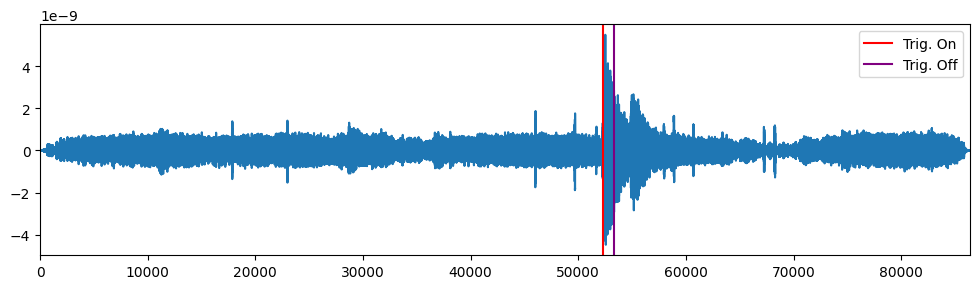

In [25]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 2
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on".
# The second column contains the indices where the trigger is turned "off".
print(on_off)

areas = []
for pair in on_off:
    area = 0
    for i in range(pair[0], pair[1], 100):
        if i >= np.max(cft) - np.std(cft):
            area += np.abs(tr_data[i])
    areas.append(area)

print(areas)

# Plot on and off triggers
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, tr_data)
# for i in np.arange(0, len(on_off)):
#     triggers = on_off[i]
#     ax.axvline(x=tr_times[triggers[0]], color="red", label="Trig. On")
#     ax.axvline(x=tr_times[triggers[1]], color="purple", label="Trig. Off")
trigger = on_off[np.argmax(areas)]
ax.axvline(x=tr_times[trigger[0]], color="red", label="Trig. On")
ax.axvline(x=tr_times[trigger[1]], color="purple", label="Trig. Off")

# Plot seismogram
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()

## Export Detection


In [21]:
# File name and start time of trace
fname = catalog["filename"][2]
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0, len(on_off)):
    triggers = on_off[i]
    on_time = starttime + datetime.timedelta(seconds=tr_times[triggers[0]])
    on_time_str = datetime.datetime.strftime(on_time, "%Y-%m-%dT%H:%M:%S.%f")
    detection_times.append(on_time_str)
    fnames.append(fname)

# Compile dataframe of detections
detect_df = pd.DataFrame(
    data={
        "filename": fnames,
        "time_abs(%Y-%m-%dT%H:%M:%S.%f)": detection_times,
        "time_rel(sec)": tr_times[triggers[0]],
    }
)
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-01-19T01:08:16.514057,73488.90566
1,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-01-19T01:17:45.117830,73488.90566
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-01-19T01:36:37.797075,73488.90566
3,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-01-19T02:05:22.476321,73488.90566
4,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-01-19T03:40:32.966887,73488.90566
